In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [6]:
import os
from pathlib import Path
#import image_data_augmentation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from textwrap import wrap
from datetime import datetime
# Import tensorflow.
import tensorflow as tf
#below 3 lines of code fixes my epoch error when fitting the model
#https://github.com/keras-team/keras/issues/14188
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, UpSampling2D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing import image

# Import augmentations functions
from image_data_augmentation import augment_data



Number of train examples: 1027
Number of test examples: 256
Number of label classes: 2
Image shape: (150, 150, 3) 



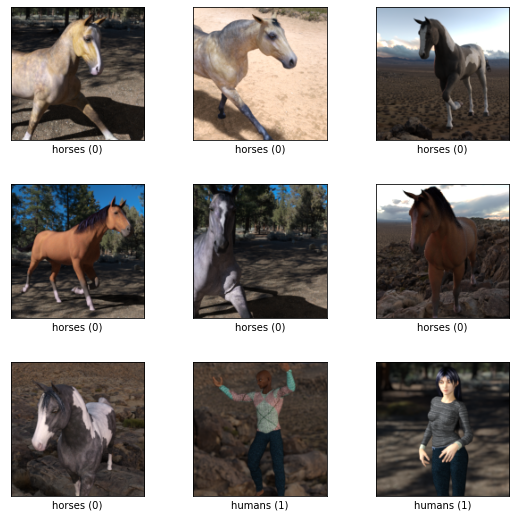

In [2]:
#loads in horses or human data set
#https://www.tensorflow.org/datasets/catalog/horses_or_humans
#^corresponding information on dataset

#Set seed
tf.random.set_seed(1)

# Load the dataset.
(train, test), info = tfds.load(
    name='horses_or_humans',
    data_dir= "./data/",
    with_info=True,
    as_supervised=True,
    split=['train', 'test'])

#reformats each image to fit into the model.
def format_image(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Reduce image to 150 x 150 x 3
    image = tf.image.resize(image, [150, 150])
    return image, label

#applaying the format_image to the train/test data
train = train.map(format_image)
test = test.map(format_image)

#sets example variables for test and train data

train_examples = info.splits['train'].num_examples
test_examples = info.splits['test'].num_examples
num_classes = info.features['label'].num_classes
(image, label) = list(train.take(1))[0]
image_shape = image.numpy().shape
#1,283 points of data within this dataset
print('Number of train examples:', train_examples)
print('Number of test examples:', test_examples)
#human or horse
print('Number of label classes:', num_classes)
print('Image shape:', image.numpy().shape, '\n')

#augment the data to confuse the model
train_augmented = train.map(augment_data)

#unagumented images to just show what it looks like
img = tfds.show_examples(train, info)
#not sure if these are real or CGI LOL

In [44]:
train_vals = np.unique(np.fromiter(train.map(lambda x, y: y), float), return_counts=True)

for train_vals, count in zip(*vals):
    print("Training Label Distrubtion:",
        int(train_vals), count)

Training Label Distrubtion: 0 500
Training Label Distrubtion: 1 527


In [3]:
# Define batch size
batch_size = 10

# Batch and shuffle train images
train_augmented_shuffled = train_augmented.shuffle(buffer_size=train_examples)
train_augmented_shuffled = train_augmented_shuffled.batch(batch_size= batch_size)

# Batch and shuffle test images
test_shuffled = test.shuffle(buffer_size=test_examples)
test_shuffled = test_shuffled.batch( batch_size= batch_size)

# Print shuffled datasets
print(train_augmented_shuffled)
print(test_shuffled)


<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>


# Model1: Simple CNN

In [35]:
#setting cnnmodel
cnnmodel = Sequential()
cnnmodel.add(Conv2D(32, (5, 5), input_shape = image_shape, activation = 'relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),   strides=(2, 2)))
cnnmodel.add(Dropout(0.5))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(128, activation = 'relu'))
cnnmodel.add(Dense(num_classes, activation = 'softmax'))

# Compile cnnmodel.
# We use Sparse Categorical Crossentropy loss and ADAM gradient descent optimizer.
cnnmodel.compile(optimizer=  'adam',
loss=tf.keras.losses.sparse_categorical_crossentropy,
metrics=['accuracy'])


In [36]:
#this cell saves the model, uncomment if need to redo
"""cnnmodel.fit(x=train_augmented_shuffled.repeat(),
          validation_data=test_shuffled.repeat(),
          epochs = 30,
          steps_per_epoch= train_examples // batch_size,
          validation_steps = test_examples // batch_size,   
          verbose = 2)
cnnmodel.save('./data/cnnmodel1.h5')"""

Epoch 1/30


102/102 - 1s - loss: 1.0815 - accuracy: 0.6020 - val_loss: 0.8168 - val_accuracy: 0.5960
Epoch 2/30
102/102 - 3s - loss: 0.5680 - accuracy: 0.7030 - val_loss: 0.7547 - val_accuracy: 0.7080
Epoch 3/30
102/102 - 3s - loss: 0.5238 - accuracy: 0.7591 - val_loss: 1.4237 - val_accuracy: 0.7000
Epoch 4/30
102/102 - 3s - loss: 0.4876 - accuracy: 0.7719 - val_loss: 0.8377 - val_accuracy: 0.7000
Epoch 5/30
102/102 - 3s - loss: 0.4514 - accuracy: 0.7965 - val_loss: 1.5517 - val_accuracy: 0.6840
Epoch 6/30
102/102 - 3s - loss: 0.4577 - accuracy: 0.8171 - val_loss: 0.9206 - val_accuracy: 0.6920
Epoch 7/30
102/102 - 3s - loss: 0.4411 - accuracy: 0.8083 - val_loss: 1.6184 - val_accuracy: 0.6920
Epoch 8/30
102/102 - 3s - loss: 0.3079 - accuracy: 0.8722 - val_loss: 1.9163 - val_accuracy: 0.6680
Epoch 9/30
102/102 - 3s - loss: 0.4111 - accuracy: 0.8230 - val_loss: 1.1708 - val_accuracy: 0.7120
Epoch 10/30
102/102 - 3s - loss: 0.3204 - accuracy: 0.8574 - val_loss: 1.3941 - val_accuracy: 0.7320
Epoch 11/3

In [45]:
#this cell saves the training loss/accuracy data, uncomment if need to redo
"""csv_logger = CSVLogger('./data/traincnnmodel.log', separator=',', append=False)
cnnmodel = cnnmodel.fit(x=train_augmented_shuffled.repeat(),
          validation_data=test_shuffled.repeat(),
          epochs = 30,
          steps_per_epoch= train_examples // batch_size,
          validation_steps = test_examples // batch_size,   
          verbose = 2, 
          callbacks=[csv_logger])"""

Epoch 1/30
102/102 - 1s - loss: 0.1857 - accuracy: 0.9343 - val_loss: 1.5946 - val_accuracy: 0.7880
Epoch 2/30
102/102 - 3s - loss: 0.1855 - accuracy: 0.9312 - val_loss: 1.7356 - val_accuracy: 0.7960
Epoch 3/30
102/102 - 3s - loss: 0.1856 - accuracy: 0.9253 - val_loss: 1.1898 - val_accuracy: 0.8240
Epoch 4/30
102/102 - 3s - loss: 0.1682 - accuracy: 0.9390 - val_loss: 1.4128 - val_accuracy: 0.7960
Epoch 5/30
102/102 - 3s - loss: 0.1796 - accuracy: 0.9430 - val_loss: 1.8384 - val_accuracy: 0.7720
Epoch 6/30
102/102 - 3s - loss: 0.1728 - accuracy: 0.9430 - val_loss: 1.7340 - val_accuracy: 0.7920
Epoch 7/30
102/102 - 3s - loss: 0.1870 - accuracy: 0.9351 - val_loss: 1.5154 - val_accuracy: 0.7880
Epoch 8/30
102/102 - 3s - loss: 0.1489 - accuracy: 0.9430 - val_loss: 1.8375 - val_accuracy: 0.7680
Epoch 9/30
102/102 - 3s - loss: 0.1206 - accuracy: 0.9499 - val_loss: 1.7222 - val_accuracy: 0.8160
Epoch 10/30
102/102 - 3s - loss: 0.1386 - accuracy: 0.9508 - val_loss: 1.8415 - val_accuracy: 0.8000

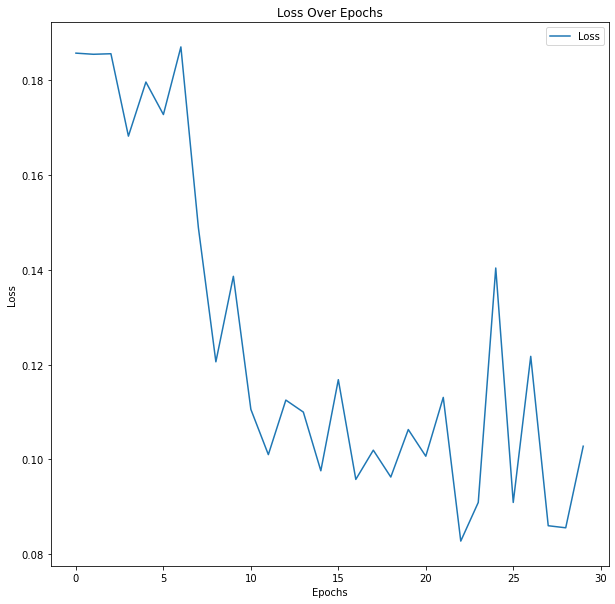

In [46]:
log_data = pd.read_csv('./data/traincnnmodel.log', sep=',', engine='python')
plt.figure(figsize=(10,10))
plt.plot(log_data['epoch'], log_data['loss'], label='Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

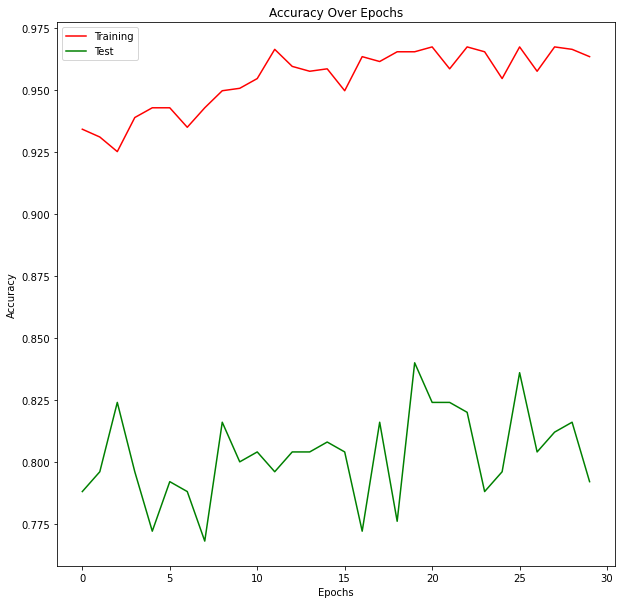

In [47]:
plt.figure(figsize=(10,10))
plt.plot(log_data['epoch'], log_data['accuracy'], color='red', label='Training')
plt.plot(log_data['epoch'], log_data['val_accuracy'], color='green', label='Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [4]:
#why is the accuracy so low in the results compared to the above graphs?
cnnmodel = load_model("./data/cnnmodel1.h5")
cnnmodel.compile(optimizer=  'adam',
loss=tf.keras.losses.sparse_categorical_crossentropy,
metrics=['accuracy'])
test_loss, test_accuracy = cnnmodel.evaluate(x=test_shuffled.take(test_examples),
                                              verbose = 0)
print('Test loss: ', test_loss, 'Test accuracy: ', test_accuracy)

Test loss:  2.0266337394714355 Test accuracy:  0.77734375


In [7]:
cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 170528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               21827712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 21,830,402
Trainable params: 21,830,402
Non-trainable params: 0
____________________________________________

# CNN Model with 2 conv layers

In [51]:
cnnmodel2 = Sequential()
cnnmodel2.add(Conv2D(64, (5, 5), input_shape=image_shape, activation='relu'))
cnnmodel2.add(MaxPooling2D(pool_size=(2, 2),   strides=(2, 2)))
cnnmodel2.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
cnnmodel2.add(MaxPooling2D(pool_size=(2, 2),   strides=(2, 2)))
cnnmodel2.add(Dropout(0.5))
cnnmodel2.add(Flatten())
cnnmodel2.add(Dense(512, activation = 'relu'))
cnnmodel2.add(Dense(50, activation = 'relu'))
cnnmodel2.add(Dense(num_classes, activation = 'softmax'))

cnnmodel2.compile(optimizer=  'adam',
  loss=tf.keras.losses.sparse_categorical_crossentropy,
  metrics=['accuracy'])

In [49]:
#uncomment to run
"""csv_logger = CSVLogger('./data/traincnnmodel2.log', separator=',', append=False)
cnnmodel2 = cnnmodel2.fit(x=train_augmented_shuffled.repeat(),
            validation_data=test_shuffled.repeat(),
            epochs = 30,
            steps_per_epoch= train_examples // batch_size,
            validation_steps = test_examples // batch_size,
            verbose = 2,
            callbacks=[csv_logger])"""

Epoch 1/30


102/102 - 1s - loss: 0.7680 - accuracy: 0.5373 - val_loss: 0.6844 - val_accuracy: 0.5440
Epoch 2/30
102/102 - 3s - loss: 0.6855 - accuracy: 0.5782 - val_loss: 0.6696 - val_accuracy: 0.6120
Epoch 3/30
102/102 - 3s - loss: 0.6763 - accuracy: 0.5733 - val_loss: 0.5600 - val_accuracy: 0.7560
Epoch 4/30
102/102 - 3s - loss: 0.6267 - accuracy: 0.6588 - val_loss: 0.7302 - val_accuracy: 0.6960
Epoch 5/30
102/102 - 3s - loss: 0.5872 - accuracy: 0.6903 - val_loss: 0.6711 - val_accuracy: 0.7240
Epoch 6/30
102/102 - 3s - loss: 0.5919 - accuracy: 0.6932 - val_loss: 1.9330 - val_accuracy: 0.5240
Epoch 7/30
102/102 - 3s - loss: 0.5575 - accuracy: 0.7178 - val_loss: 0.4955 - val_accuracy: 0.7960
Epoch 8/30
102/102 - 3s - loss: 0.5004 - accuracy: 0.7630 - val_loss: 1.1332 - val_accuracy: 0.7000
Epoch 9/30
102/102 - 3s - loss: 0.4824 - accuracy: 0.7827 - val_loss: 1.3392 - val_accuracy: 0.6280
Epoch 10/30
102/102 - 3s - loss: 0.5412 - accuracy: 0.7493 - val_loss: 1.4227 - val_accuracy: 0.7160
Epoch 11/3

In [52]:
#uncomment to run
"""cnnmodel2.fit(x=train_augmented_shuffled.repeat(),
            validation_data=test_shuffled.repeat(),
            epochs = 30,
            steps_per_epoch= train_examples // batch_size,
            validation_steps = test_examples // batch_size,
            verbose = 2)
cnnmodel2.save('./data/cnnmodel2.h5')"""

Epoch 1/30


102/102 - 1s - loss: 0.7620 - accuracy: 0.5176 - val_loss: 0.6921 - val_accuracy: 0.5040
Epoch 2/30
102/102 - 3s - loss: 0.6921 - accuracy: 0.5615 - val_loss: 0.5469 - val_accuracy: 0.6920
Epoch 3/30
102/102 - 3s - loss: 0.6715 - accuracy: 0.6028 - val_loss: 0.5806 - val_accuracy: 0.7320
Epoch 4/30
102/102 - 3s - loss: 0.6646 - accuracy: 0.5654 - val_loss: 0.4834 - val_accuracy: 0.7200
Epoch 5/30
102/102 - 3s - loss: 0.6453 - accuracy: 0.6146 - val_loss: 0.8932 - val_accuracy: 0.7640
Epoch 6/30
102/102 - 3s - loss: 0.6224 - accuracy: 0.6362 - val_loss: 1.0882 - val_accuracy: 0.6800
Epoch 7/30
102/102 - 3s - loss: 0.6001 - accuracy: 0.6863 - val_loss: 0.6149 - val_accuracy: 0.6320
Epoch 8/30
102/102 - 3s - loss: 0.5515 - accuracy: 0.7345 - val_loss: 1.2312 - val_accuracy: 0.7520
Epoch 9/30
102/102 - 3s - loss: 0.5773 - accuracy: 0.7227 - val_loss: 0.8406 - val_accuracy: 0.6440
Epoch 10/30
102/102 - 3s - loss: 0.5479 - accuracy: 0.7276 - val_loss: 1.2756 - val_accuracy: 0.7120
Epoch 11/3

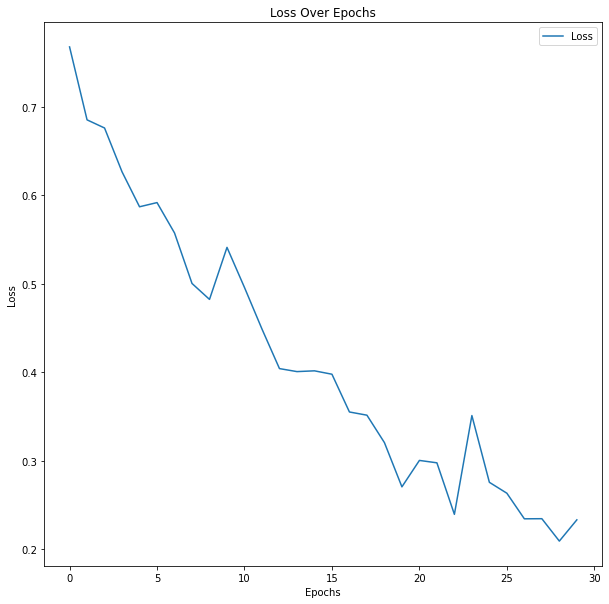

In [53]:
log_data = pd.read_csv('./data/traincnnmodel2.log', sep=',', engine='python')
plt.figure(figsize=(10,10))
plt.plot(log_data['epoch'], log_data['loss'], label='Loss',)
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

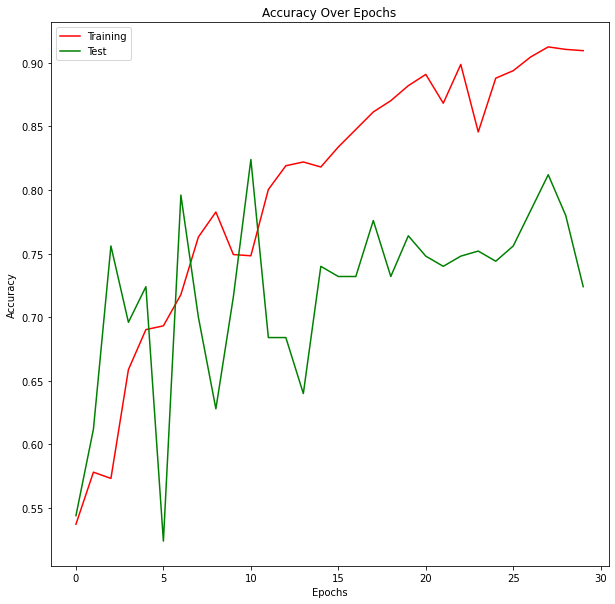

In [54]:
plt.figure(figsize=(10,10))
plt.plot(log_data['epoch'], log_data['accuracy'], color='red', label='Training')
plt.plot(log_data['epoch'], log_data['val_accuracy'], color='green', label='Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [5]:
cnn_model_2 = load_model('./data/cnnmodel2.h5')
cnn_model_2.compile(optimizer=  'adam',
  loss=tf.keras.losses.sparse_categorical_crossentropy,
  metrics=['accuracy'])
test_loss, test_accuracy = cnn_model_2.evaluate(x=test_shuffled.take(test_examples), 
                                                verbose = 0)
print('Test loss: ', test_loss, 'Test accuracy: ', test_accuracy)

Test loss:  2.2243287563323975 Test accuracy:  0.73046875


In [56]:
cnn_model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 146, 146, 64)      4864      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)              

# CNN Model with 3 conv layers

In [17]:
#adding a 3rd convulational layer
cnnmodel3 = Sequential()
cnnmodel3.add(Conv2D(64, (5, 5), input_shape=image_shape, activation='relu'))
cnnmodel3.add(MaxPooling2D(pool_size=(2, 2),   strides=(2, 2)))
cnnmodel3.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
cnnmodel3.add(MaxPooling2D(pool_size=(2, 2),   strides=(2, 2)))
cnnmodel3.add(Conv2D(16, (2, 2), input_shape=image_shape, activation='relu'))
cnnmodel3.add(MaxPooling2D(pool_size=(2, 2),   strides=(2, 2)))
cnnmodel3.add(Dropout(0.5))
cnnmodel3.add(Flatten())
cnnmodel3.add(Dense(512, activation = 'relu'))
cnnmodel3.add(Dense(50, activation = 'relu'))
cnnmodel3.add(Dense(num_classes, activation = 'softmax'))

# Compile cnnmodel3.
# We use logarithmic loss and ADAM gradient descent optimizer.
cnnmodel3.compile(optimizer=  'adam',
  loss=tf.keras.losses.sparse_categorical_crossentropy,
  metrics=['accuracy'])

In [18]:
"""cnnmodel3.fit(x=train_augmented_shuffled.repeat(),
            validation_data=test_shuffled.repeat(),
            epochs = 30,
            steps_per_epoch= train_examples // batch_size,
            validation_steps = test_examples // batch_size,
            verbose = 2)
cnnmodel3.save('./data/cnnmodel3.h5')"""

Epoch 1/30
102/102 - 1s - loss: 0.7014 - accuracy: 0.5157 - val_loss: 0.6932 - val_accuracy: 0.5040
Epoch 2/30
102/102 - 3s - loss: 0.6933 - accuracy: 0.5025 - val_loss: 0.6921 - val_accuracy: 0.5040
Epoch 3/30
102/102 - 3s - loss: 0.6348 - accuracy: 0.6509 - val_loss: 0.5933 - val_accuracy: 0.6400
Epoch 4/30
102/102 - 3s - loss: 0.6106 - accuracy: 0.6627 - val_loss: 2.0588 - val_accuracy: 0.5920
Epoch 5/30
102/102 - 3s - loss: 0.5831 - accuracy: 0.7070 - val_loss: 1.2757 - val_accuracy: 0.5720
Epoch 6/30
102/102 - 3s - loss: 0.5195 - accuracy: 0.7552 - val_loss: 2.1363 - val_accuracy: 0.5920
Epoch 7/30
102/102 - 3s - loss: 0.5055 - accuracy: 0.7473 - val_loss: 1.5668 - val_accuracy: 0.5520
Epoch 8/30
102/102 - 3s - loss: 0.4892 - accuracy: 0.7719 - val_loss: 2.0640 - val_accuracy: 0.6280
Epoch 9/30
102/102 - 3s - loss: 0.4088 - accuracy: 0.8132 - val_loss: 1.5614 - val_accuracy: 0.6640
Epoch 10/30
102/102 - 3s - loss: 0.3791 - accuracy: 0.8328 - val_loss: 1.2463 - val_accuracy: 0.7080

In [19]:
"""csv_logger = CSVLogger('./data/traincnnmodel3.log', separator=',', append=False)
cnnmodel3 = cnnmodel3.fit(x=train_augmented_shuffled.repeat(),
            validation_data=test_shuffled.repeat(),
            epochs = 30,
            steps_per_epoch= train_examples // batch_size,
            validation_steps = test_examples // batch_size,
            verbose = 2,
            callbacks=[csv_logger])"""

Epoch 1/30
102/102 - 1s - loss: 0.1573 - accuracy: 0.9461 - val_loss: 0.8588 - val_accuracy: 0.8520
Epoch 2/30
102/102 - 3s - loss: 0.1749 - accuracy: 0.9420 - val_loss: 1.3609 - val_accuracy: 0.8200
Epoch 3/30
102/102 - 3s - loss: 0.1622 - accuracy: 0.9400 - val_loss: 1.2998 - val_accuracy: 0.8240
Epoch 4/30
102/102 - 3s - loss: 0.1359 - accuracy: 0.9499 - val_loss: 1.1169 - val_accuracy: 0.8480
Epoch 5/30
102/102 - 3s - loss: 0.1495 - accuracy: 0.9371 - val_loss: 1.1468 - val_accuracy: 0.8320
Epoch 6/30
102/102 - 3s - loss: 0.1190 - accuracy: 0.9518 - val_loss: 1.8074 - val_accuracy: 0.8000
Epoch 7/30
102/102 - 3s - loss: 0.1470 - accuracy: 0.9518 - val_loss: 1.8834 - val_accuracy: 0.7440
Epoch 8/30
102/102 - 3s - loss: 0.0997 - accuracy: 0.9617 - val_loss: 2.1093 - val_accuracy: 0.8240
Epoch 9/30
102/102 - 3s - loss: 0.1228 - accuracy: 0.9626 - val_loss: 2.0283 - val_accuracy: 0.8120
Epoch 10/30
102/102 - 3s - loss: 0.1162 - accuracy: 0.9597 - val_loss: 1.7871 - val_accuracy: 0.7400

In [66]:
cnn_model_3 = load_model('./data/cnnmodel3.h5')
cnn_model_3.compile(optimizer=  'adam',
  loss=tf.keras.losses.sparse_categorical_crossentropy,
  metrics=['accuracy'])
test_loss, test_accuracy = cnn_model_3.evaluate(x=test_shuffled.take(test_examples), 
                                                verbose = 0)
print('Test loss: ', test_loss, 'Test accuracy: ', test_accuracy)

Test loss:  1.3713877201080322 Test accuracy:  0.7890625


In [34]:
cnn_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 146, 146, 64)      4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 16)        2064      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 16)       

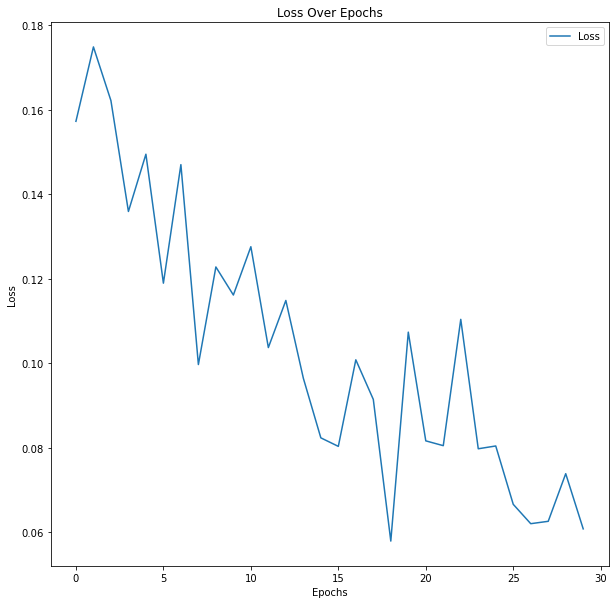

In [60]:
log_data = pd.read_csv('./data/traincnnmodel3.log', sep=',', engine='python')
plt.figure(figsize=(10,10))
plt.plot(log_data['epoch'], log_data['loss'], label='Loss',)
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

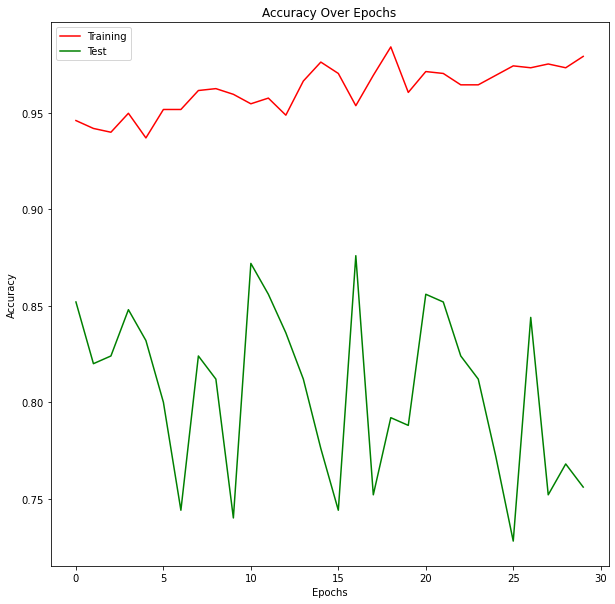

In [61]:
plt.figure(figsize=(10,10))
plt.plot(log_data['epoch'], log_data['accuracy'], color='red', label='Training')
plt.plot(log_data['epoch'], log_data['val_accuracy'], color='green', label='Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

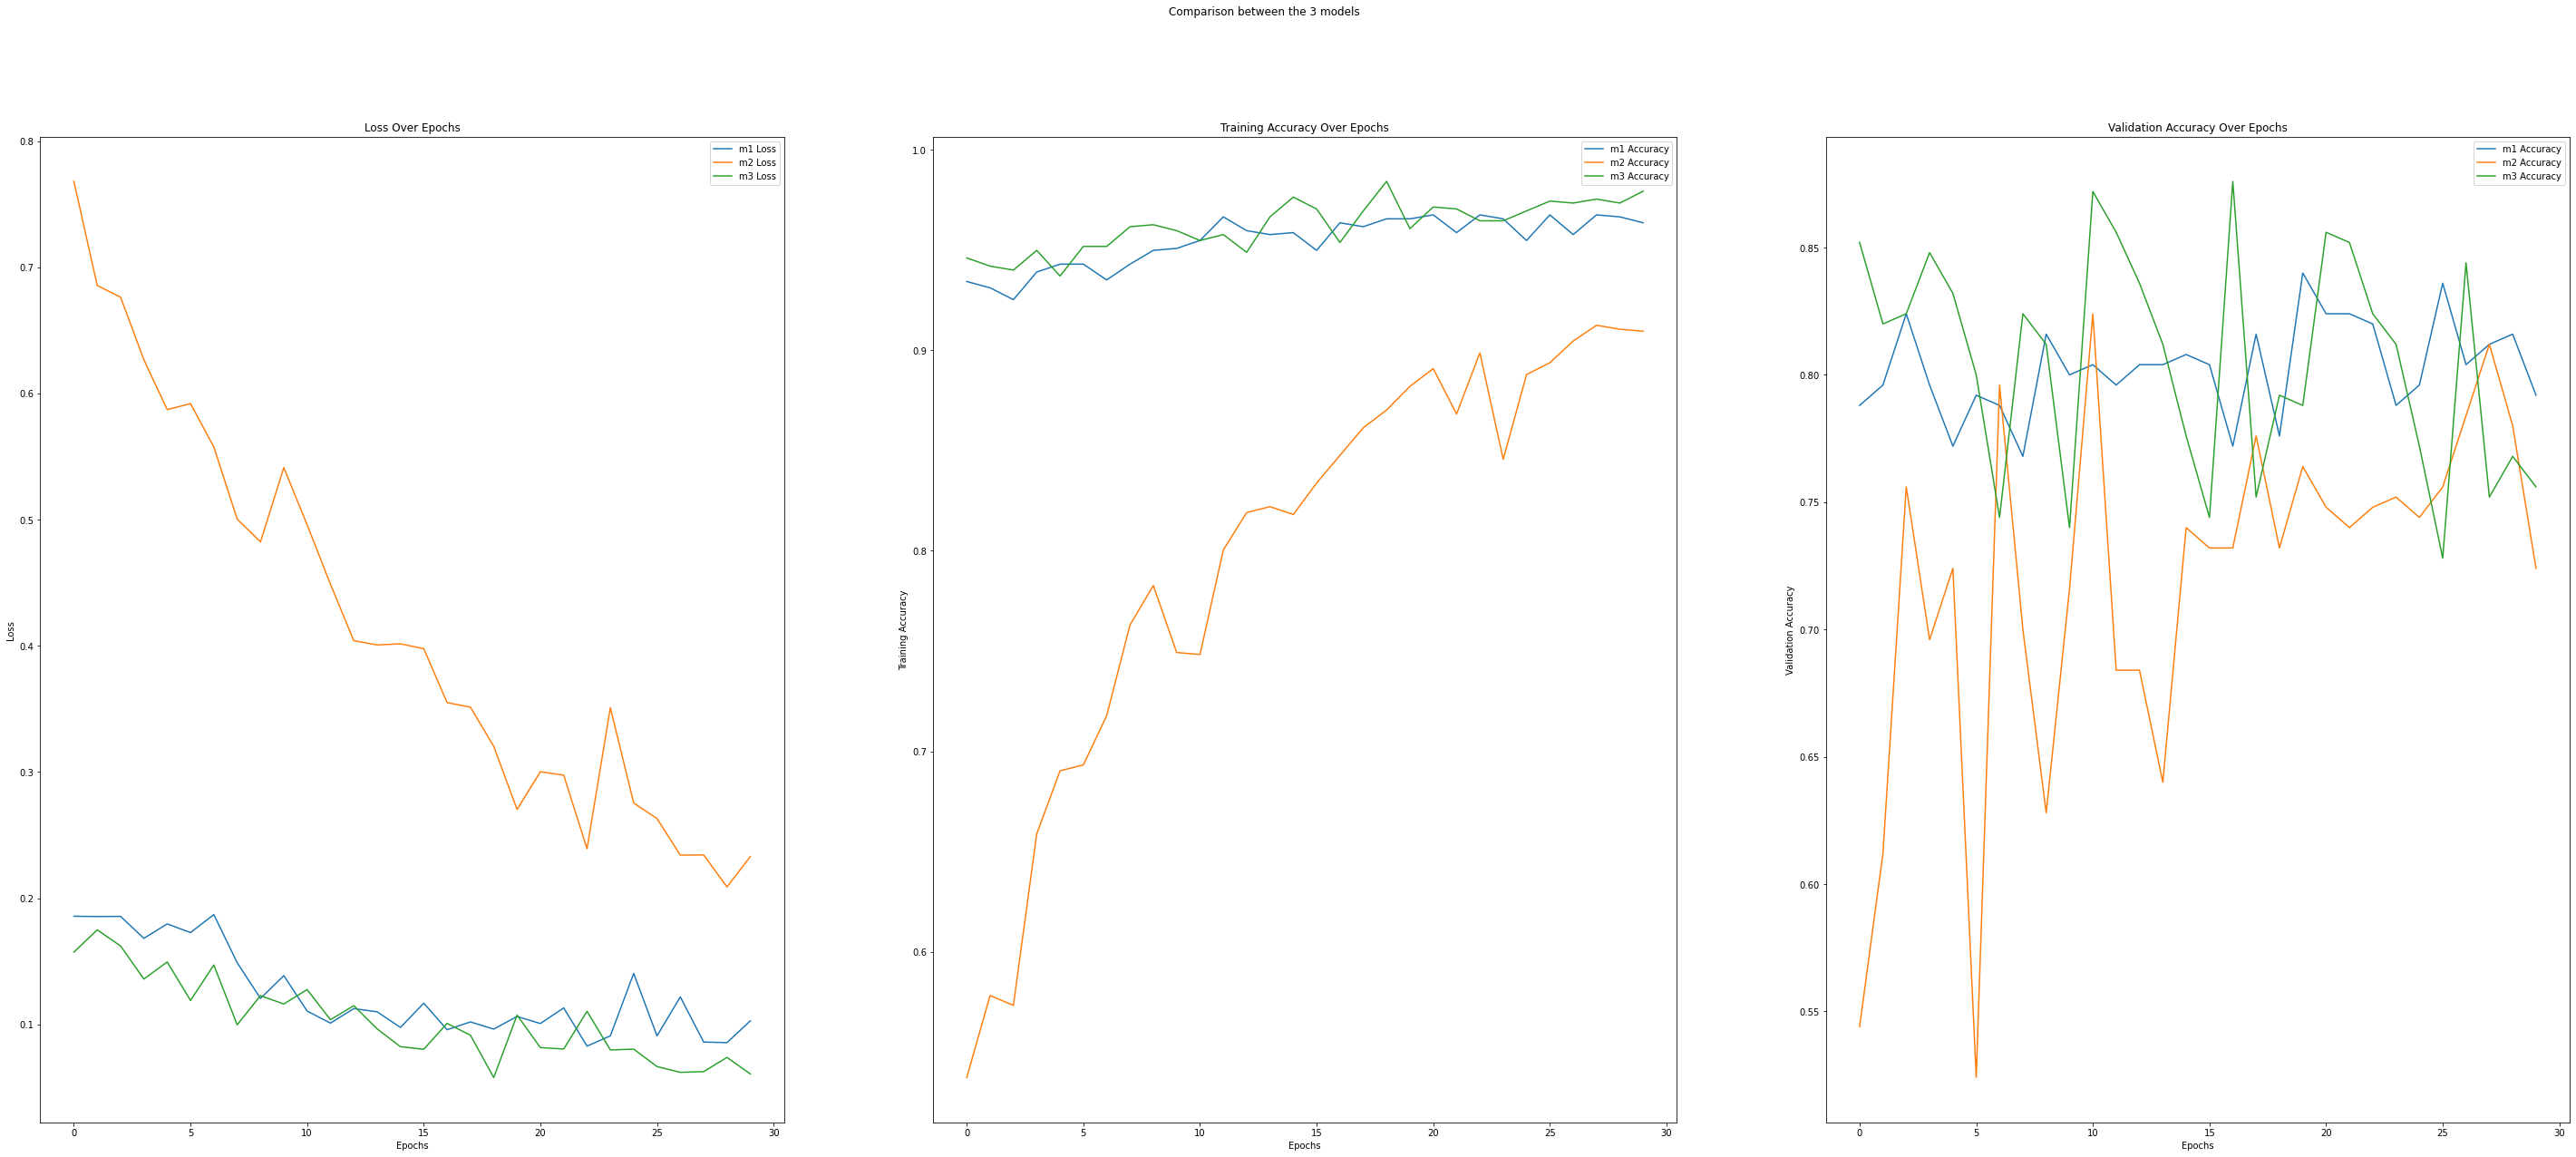

In [59]:
m1 = pd.read_csv('./data/traincnnmodel.log', sep=',', engine='python')
m2 = pd.read_csv('./data/traincnnmodel2.log', sep=',', engine='python')
m3 = pd.read_csv('./data/traincnnmodel3.log', sep=',', engine='python')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(50,20))
fig.suptitle('Comparison between the 3 models')

ax1.set_title('Loss Over Epochs')
ax1.plot(m1['epoch'], m1['loss'], label='m1 Loss',)
ax1.plot(m1['epoch'], m2['loss'], label='m2 Loss',)
ax1.plot(m1['epoch'], m3['loss'], label='m3 Loss',)
ax1.legend()
ax1.set(xlabel="Epochs", ylabel="Loss")

ax2.set_title('Training Accuracy Over Epochs')
ax2.plot(m1['epoch'], m1['accuracy'], label='m1 Accuracy',)
ax2.plot(m1['epoch'], m2['accuracy'], label='m2 Accuracy',)
ax2.plot(m1['epoch'], m3['accuracy'], label='m3 Accuracy',)
ax2.legend()
ax2.set(xlabel="Epochs", ylabel="Training Accuracy")

ax3.set_title('Validation Accuracy Over Epochs')
ax3.plot(m1['epoch'], m1['val_accuracy'], label='m1 Accuracy',)
ax3.plot(m1['epoch'], m2['val_accuracy'], label='m2 Accuracy',)
ax3.plot(m1['epoch'], m3['val_accuracy'], label='m3 Accuracy',)
ax3.legend()
ax3.set(xlabel="Epochs", ylabel="Validation Accuracy")

plt.show()


# Test 1
<img src='./data/realhorse.jpg'>

In [11]:
#loading and optimizing model
cnn_model_3 = load_model('./data/cnnmodel3.h5')
cnn_model_3.compile(optimizer=  'adam',
  loss=tf.keras.losses.sparse_categorical_crossentropy,
  metrics=['accuracy'])
#load and reformat image
img = image.load_img('./data/realhorse.jpg', target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

print(cnn_model_3.predict_classes(images, batch_size=10))

[0]


# Test 2
<img src='./data/guy.jpg'>

In [1]:
#load in and reformat image to fit into model
img = image.load_img('./data/guy.jpg', target_size=(150,150,3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
print(cnn_model_3.predict_classes(images, batch_size=10))

NameError: name 'image' is not defined

# Test 3
<img src='./data/thanos.jpg'>

In [9]:
img = image.load_img('./data/thanos.jpg', target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
print(cnn_model_3.predict_classes(images, batch_size=10))

[0]


# Test 4
<img src='./data/bojack.jpg'>

In [10]:
img = image.load_img('./data/bojack.jpg', target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
print(cnn_model_3.predict_classes(images, batch_size=10))

[1]


# Auto encoder Attempt

Was recieving OOM errors when trying to run auto encoder code. Not sure whether the issue was utilization of GPU/CPU on desktop or package versions

In [46]:
((X_train_raw,_), (X_test_raw,_)) = tfds.load(name='horses_or_humans',
                                              data_dir= './data',
                                              as_supervised=True,
                                              batch_size = -1,
                                              split=['train', 'test'])

In [47]:
def format_example(image):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [75, 75])
    return image

X_train = format_example(X_train_raw)
X_test = format_example(X_test_raw)

# Save shape for model and visualizing results
three_d_shape = X_train.shape[1:]
print(three_d_shape)

(75, 75, 3)


In [48]:
# Flatten image to 1-D
X_train = tfds.as_numpy(X_train).reshape(len(X_train), np.prod(X_train.shape[1:]))
X_test = tfds.as_numpy(X_test).reshape(len(X_test), np.prod(X_test.shape[1:]))

# Save shape for later
flattened_shape = X_train.shape[1]
print(flattened_shape)


16875


In [49]:
input_img = Input(shape=(flattened_shape,))

# Define the encoder dimension
encoding_dim = 512
encoded_layer = Dense(encoding_dim, activation = 'relu')(input_img)
decoded_layer = Dense(flattened_shape, activation = 'sigmoid')(encoded_layer)


In [50]:
# Define the model which will map the input to its reconstructed output
autoencoder_simple = Model(input_img, decoded_layer)
autoencoder_simple.summary()
# Compile the model
autoencoder_simple.compile(loss = 'binary_crossentropy',
                           optimizer = 'adam')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16875)]           0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               8640512   
_________________________________________________________________
dense_15 (Dense)             (None, 16875)             8656875   
Total params: 17,297,387
Trainable params: 17,297,387
Non-trainable params: 0
_________________________________________________________________


In [51]:
"""autoencoder_simple.fit(X_train, X_train,
                       epochs = 20,
                       batch_size = 200,
                       shuffle = True,
                       validation_data = (X_test, X_test))
autoencoder_simple.save('./data/aemodel.h5')"""

Epoch 1/20
6/6 [==============================] - 0s 27ms/step - loss: 0.6939 - val_loss: 0.6621
Epoch 2/20
6/6 [==============================] - 0s 18ms/step - loss: 0.6839 - val_loss: 0.5481
Epoch 3/20
6/6 [==============================] - 0s 18ms/step - loss: 0.6700 - val_loss: 0.4923
Epoch 4/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6588 - val_loss: 0.4498
Epoch 5/20
6/6 [==============================] - 0s 18ms/step - loss: 0.6524 - val_loss: 0.4665
Epoch 6/20
6/6 [==============================] - 0s 18ms/step - loss: 0.6478 - val_loss: 0.4819
Epoch 7/20
6/6 [==============================] - 0s 18ms/step - loss: 0.6458 - val_loss: 0.4896
Epoch 8/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6439 - val_loss: 0.4720
Epoch 9/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6416 - val_loss: 0.4322
Epoch 10/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6409 - val_loss: 0.4262
Epoch 11/20
6/6 [============

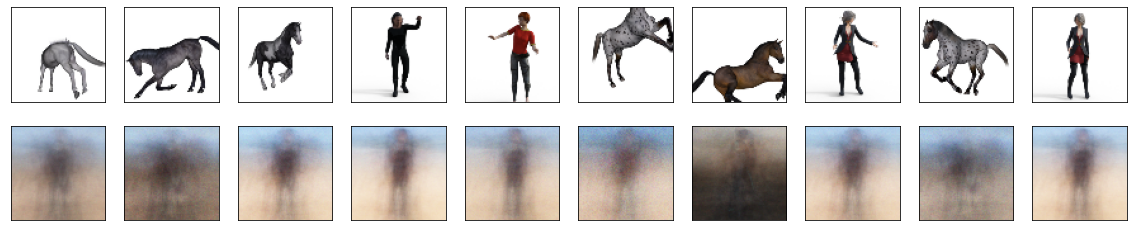

In [54]:
ae_model = load_model('./data/aemodel.h5')
# Decode the encoded images
reconstructed_imgs = ae_model.predict(X_test)
n = 10  # Choose the number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(three_d_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstucted image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(three_d_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [55]:
input_img = Input(shape=(flattened_shape,))
encoded_layer = Dense(512, activation='relu')(input_img)
encoded_layer = Dense(128, activation='relu')(encoded_layer)
encoded_layer = Dense(64, activation='relu')(encoded_layer)
encoded_layer = Dense(32, activation='relu')(encoded_layer)


decoded_layer = Dense(32, activation='relu')(encoded_layer)
decoded_layer = Dense(64, activation='relu')(decoded_layer)
decoded_layer = Dense(128, activation='relu')(decoded_layer)
decoded_layer = Dense(512, activation='relu')(decoded_layer)
decoded_layer = Dense(flattened_shape, activation='sigmoid')(decoded_layer)

autoencoder_deep = Model(input_img, decoded_layer)
autoencoder_deep.compile(optimizer='adam', loss='binary_crossentropy')

In [56]:
"""autoencoder_deep.fit(X_train, X_train,
                     epochs = 20,
                     batch_size = 200,
                     shuffle = True,
                     validation_data = (X_test, X_test))
autoencoder_deep.save('./data/aedeepmodel.h5')"""

Epoch 1/20
6/6 [==============================] - 0s 32ms/step - loss: 0.6908 - val_loss: 0.5669
Epoch 2/20
6/6 [==============================] - 0s 18ms/step - loss: 0.6730 - val_loss: 0.5188
Epoch 3/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6665 - val_loss: 0.5042
Epoch 4/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6625 - val_loss: 0.4411
Epoch 5/20
6/6 [==============================] - 0s 16ms/step - loss: 0.6594 - val_loss: 0.4506
Epoch 6/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6570 - val_loss: 0.4534
Epoch 7/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6519 - val_loss: 0.3809
Epoch 8/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6553 - val_loss: 0.4810
Epoch 9/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6480 - val_loss: 0.4561
Epoch 10/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6447 - val_loss: 0.4721
Epoch 11/20
6/6 [============

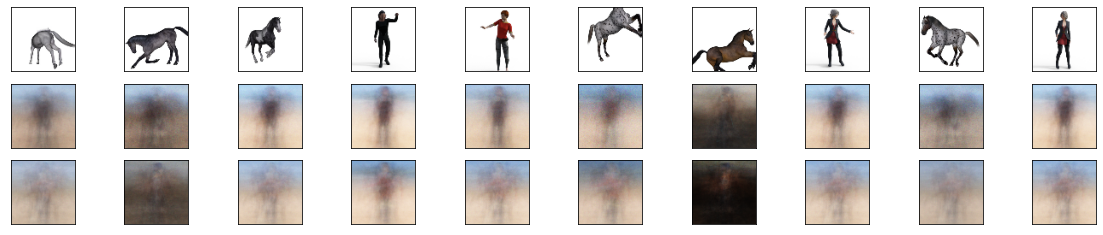

In [57]:
autoencoder_deep = load_model('./data/aedeepmodel.h5')

reconstructed_imgs_deep = autoencoder_deep.predict(X_test)
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(three_d_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstucted simple model images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(three_d_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction deep model images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(reconstructed_imgs_deep[i].reshape(three_d_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()



In [58]:
def format_example(image):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [300, 300])
    return image

X_train = tfds.as_numpy(format_example(X_train_raw))
X_test = tfds.as_numpy(format_example(X_test_raw))

# Save shape for model and visualizing results
three_d_shape = X_train.shape[1:]
print(three_d_shape)


(300, 300, 3)


In [59]:
input_img = Input(shape=(three_d_shape))


# Define three convolutional layers for the encoder
encoded_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
encoded_layer = MaxPooling2D((2, 2), padding='same')(encoded_layer)
encoded_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer)
encoded_layer = MaxPooling2D((2, 2), padding='same')(encoded_layer)
encoded_layer = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer)
encoded_layer = MaxPooling2D((2, 2), padding='same')(encoded_layer)
encoded_layer = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_layer)
encoded_layer = MaxPooling2D((2, 2), padding='same')(encoded_layer)

# Define three convolutional layers for the decoder
decoded_layer = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_layer)
decoded_layer = UpSampling2D((2, 2))(decoded_layer)
decoded_layer = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded_layer)
decoded_layer = UpSampling2D((2, 2))(decoded_layer)
decoded_layer = Conv2D(32, (3, 3), activation='relu',padding='same')(decoded_layer)
decoded_layer = UpSampling2D((2, 2))(decoded_layer)
decoded_layer = Conv2D(64, (3, 3), activation='relu')(decoded_layer)
decoded_layer = UpSampling2D((2, 2))(decoded_layer)
decoded_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded_layer)


In [60]:
autoencoder_cnn = Model(input_img, decoded_layer)
autoencoder_cnn.compile(optimizer = 'adam',
                        loss='binary_crossentropy')

In [61]:
#too many layers in the two cells above might ned to reduce
autoencoder_cnn.fit(X_train, X_train,
                    epochs = 15,
                    batch_size = 200,
                    shuffle = True,
                    validation_data = (X_test, X_test))
autoencoder_cnn.save('./data/aecnn.h5')

Epoch 1/15


ResourceExhaustedError:  OOM when allocating tensor with shape[200,64,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_7/conv2d_7/Relu (defined at <ipython-input-61-093e8bed3682>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_20622]

Function call stack:
train_function


In [ ]:
autoencoder_cnn = load_model('./data/aecnn.h5')
reconstructed_imgs_cnn = autoencoder_cnn.predict(X_test)